In [1]:
import sys 
import os

sys.path.append(os.path.abspath("../src"))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, 
    brier_score_loss, 
    f1_score,
    precision_score,
    recall_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    get_scorer_names
)

from lightgbm import LGBMClassifier

#import optuna

In [3]:
df = pd.read_csv("../data/raw/telco-customer-churn-dataset.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- The variable *SeniorCitizen* has a int64 dtype, but, in reality, is a one hot encoded categorical variable. 
- The variable *TotalCharges* has a object dtype, but it should be a float.  

In [6]:
df["TotalCharges"].value_counts()

TotalCharges
20.2      11
          11
19.75      9
19.65      8
19.9       8
          ..
1990.5     1
7362.9     1
346.45     1
306.6      1
108.15     1
Name: count, Length: 6531, dtype: int64

It seems like, for some observations, the variable has ' ' values. This is making pandas read this column as an object instead of a float. I'll see the distribution of the non missing values, in order to properly impute those missing values.

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


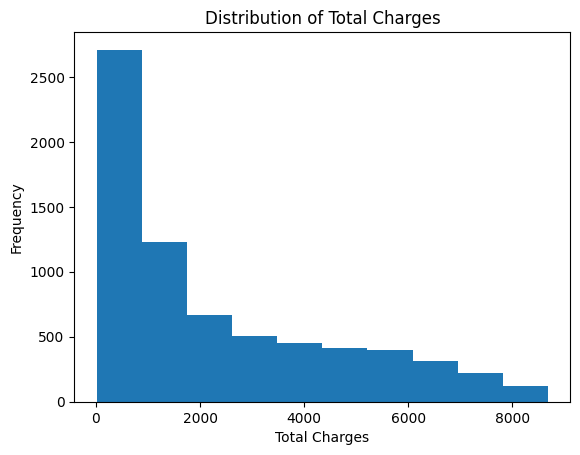

In [7]:
filled_total_charges = (
    df
    .loc[df["TotalCharges"] != ' ', "TotalCharges"]
    .astype("float")
)

print(filled_total_charges.describe())
filled_total_charges.plot(kind="hist")
plt.title("Distribution of Total Charges")
plt.xlabel("Total Charges")
plt.show()

The histogram and the statistics calculated from the distribution of the *TotalCharges* variable indicates that it's skewed to the right. In this case, it's better to impute the values with the median.  

In [22]:
df_filled = df.copy()

df_filled["TotalCharges"] = (
    df_filled["TotalCharges"]
    .replace(' ', filled_total_charges.median())
    .astype("float")
)

In [23]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- Qualitative variables:
    1. customerID: customer identification; this variable will not enter in the analysis.
    2. gender: whether the customer is a male or a female.
    3. SeniorCitizen: whether the customer is a senior citizen or not (1, 0).
    4. Partner: whether the customer has a partner or not (Yes, No).
    5. Dependents: whether the customer has dependents or not (Yes, No).
    6. PhoneService: whether the customer has a phone service or not (Yes, No).
    7. MultipleLines: whether the customer has multiple lines or not (Yes, No, No phone service).
    8. InternetService: customer's internet service provider (DSL, Fiber optic, No).
    9. OnlineSecurity: whether the customer has online security or not (Yes, No, No internet service).
    10. OnlineBackup: whether the customer has online backup or not (Yes, No, No internet service).
    11. DeviceProtection: whether the customer has device protection or not (Yes, No, No internet service).
    12. TechSupport: whether the customer has tech support or not (Yes, No, No internet service).
    13. StreamingTV: whether the customer has streaming TV or not (Yes, No, No internet service).
    14. StreamingMovies: whether the customer has streaming movies or not (Yes, No, No internet service).
    15. Contract: the contract of the customer (Month-to-month, One year, Two year).
    16. PaperlessBilling: whether the customer has paperless billing or not (Yes, No).
    17. PaymentMethod: the customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
    18. Churn: wheter the customer has churned or not (Yes or No); the target.
- Quantitative variables: 
    1. tenure: number of months the customer has stayed with the company.
    2. MonthlyCharges: the amount charged to the customer monthly.
    3. TotalCharges: the total amount charged to the customer.

I'll change the values of the *SeniorCitizen* column for it to be equivalent with the other qualitative variables.

In [10]:
df_filled["SeniorCitizen"] = df_filled["SeniorCitizen"].replace({0: "No", 1: "Yes"})

feat_cat = [col for col in df_filled.select_dtypes(include="object").columns if col not in ["customerID", "Churn"]]
feat_num = df_filled.select_dtypes(exclude="object").columns.to_list()

df_cats = pd.concat(
    [
        df_filled["customerID"].copy(),
        df_filled[feat_cat],#.astype("category").copy(),
        df_filled[feat_num].copy(),
        df_filled["Churn"].replace({"No": 0, "Yes": 1}).copy()
    ],
    axis=1
)

C:\Users\leona\AppData\Local\Temp\ipykernel_13920\2110317196.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled["Churn"].replace({"No": 0, "Yes": 1}).copy()


In [11]:
df_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [12]:
df_cats.to_pickle("../data/processed/df_log_reg.pkl")

In [13]:
df_cats.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,1,29.85,29.85,0
1,5575-GNVDE,Male,No,No,No,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,34,56.95,1889.50,0
2,3668-QPYBK,Male,No,No,No,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,2,53.85,108.15,1
3,7795-CFOCW,Male,No,No,No,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),45,42.30,1840.75,0
4,9237-HQITU,Female,No,No,No,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,2,70.70,151.65,1


C:\Users\leona\AppData\Local\Temp\ipykernel_13920\1480895947.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=90)


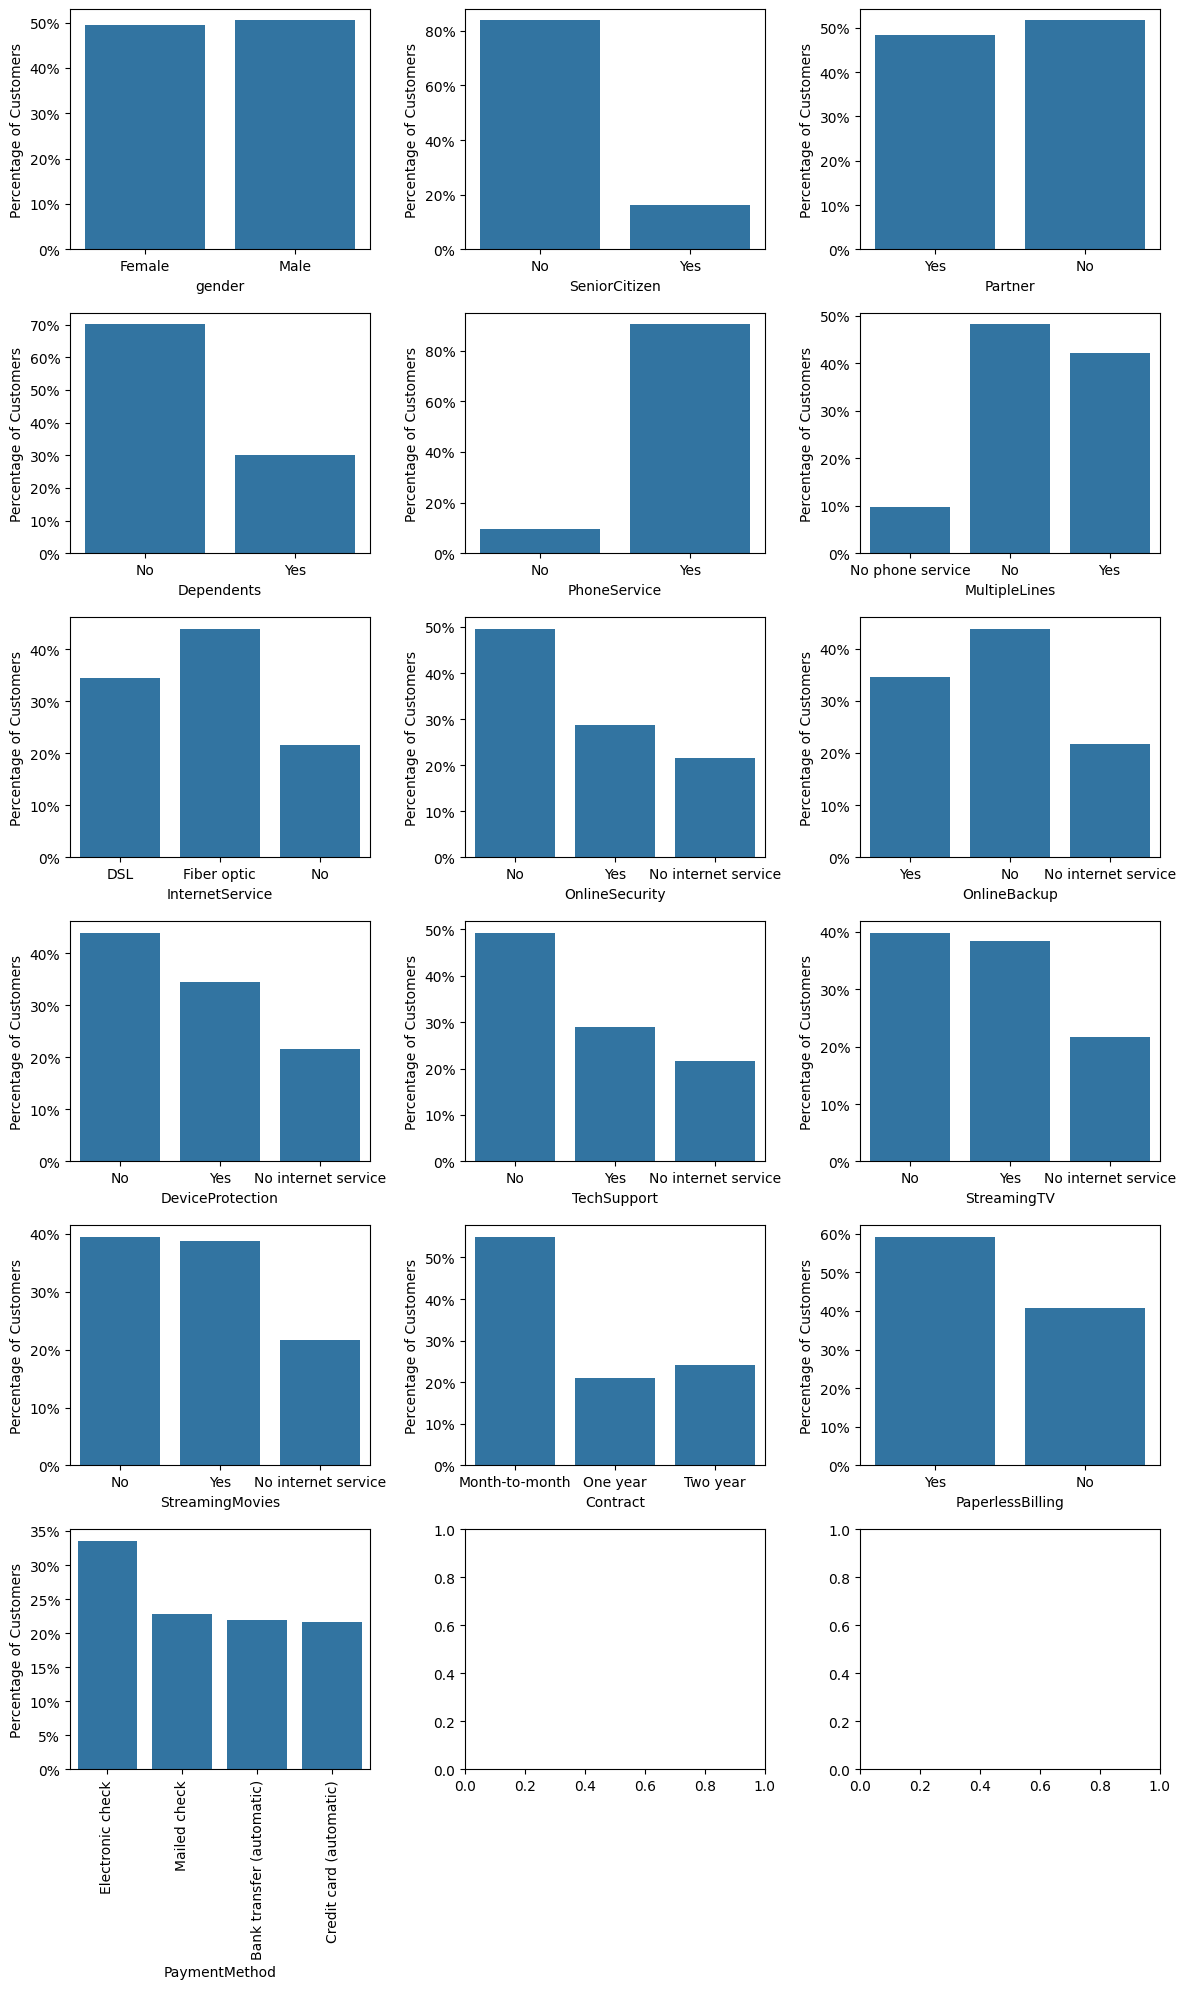

In [14]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12, 20))
ax = ax.flatten()

for idx, col in enumerate(feat_cat):
    sns.countplot(data=df_cats, x=col, ax=ax[idx], stat="percent")
    
    ax[idx].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax[idx].set_ylabel("Percentage of Customers")
    
    if col == "PaymentMethod":
        ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=90)
    
    #if idx == 17:
    #    fig.delaxes(ax[idx])

plt.tight_layout()
plt.show()

The columns *PhoneService* and *MultipleLines* are redundant when *PhoneService* is "No", because people that don't have phone service, can't have multiple lines (obviously!). Therefore, I will change every occurrence of "No phone service" in the column *MultipleLines* to "No", transforming it into a dichotomous variable, with only the "No" and "Yes" categories.

The same reasoning can be applied to the following columns, regarding internet service:
1. *InternetService*;
2. *OnlineSecurity*;
3. *OnlineBackup*;
4. *DeviceProtection*;
5. *TechSupport*;
6. *StreamingTV*;
7. *StreamingMovies*.


In [15]:
df_cats = df_cats.replace(
    to_replace={
        "MultipleLines": {"No phone service": "No"},
        "OnlineSecurity": {"No internet service": "No"},
        "OnlineBackup": {"No internet service": "No"},
        "DeviceProtection": {"No internet service": "No"},
        "TechSupport": {"No internet service": "No"},
        "StreamingTV": {"No internet service": "No"},
        "StreamingMovies": {"No internet service": "No"},
    }
) 

In [16]:
df_cats.to_pickle("../data/processed/df_log_reg.pkl")

In [33]:
cont_table = pd.crosstab(df_cats["PaperlessBilling"], df_cats["PaymentMethod"], margins=True, normalize=True).round(4)
cont_table

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,All
PaperlessBilling,,,,,
No,0.0927,0.0909,0.0885,0.1357,0.4078
Yes,0.1265,0.1252,0.2473,0.0931,0.5922
All,0.2192,0.2161,0.3358,0.2289,1.0000


In [34]:
cont_table = pd.crosstab(df_cats["InternetService"], df_cats["OnlineSecurity"], margins=True, normalize=False).round(4)
cont_table

OnlineSecurity,No,Yes,All
InternetService,,,
DSL,1241,1180,2421
Fiber optic,2257,839,3096
No,1526,0,1526
All,5024,2019,7043


C:\Users\Leonardo.Oliveira\AppData\Local\Temp\ipykernel_39464\71772532.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=90)


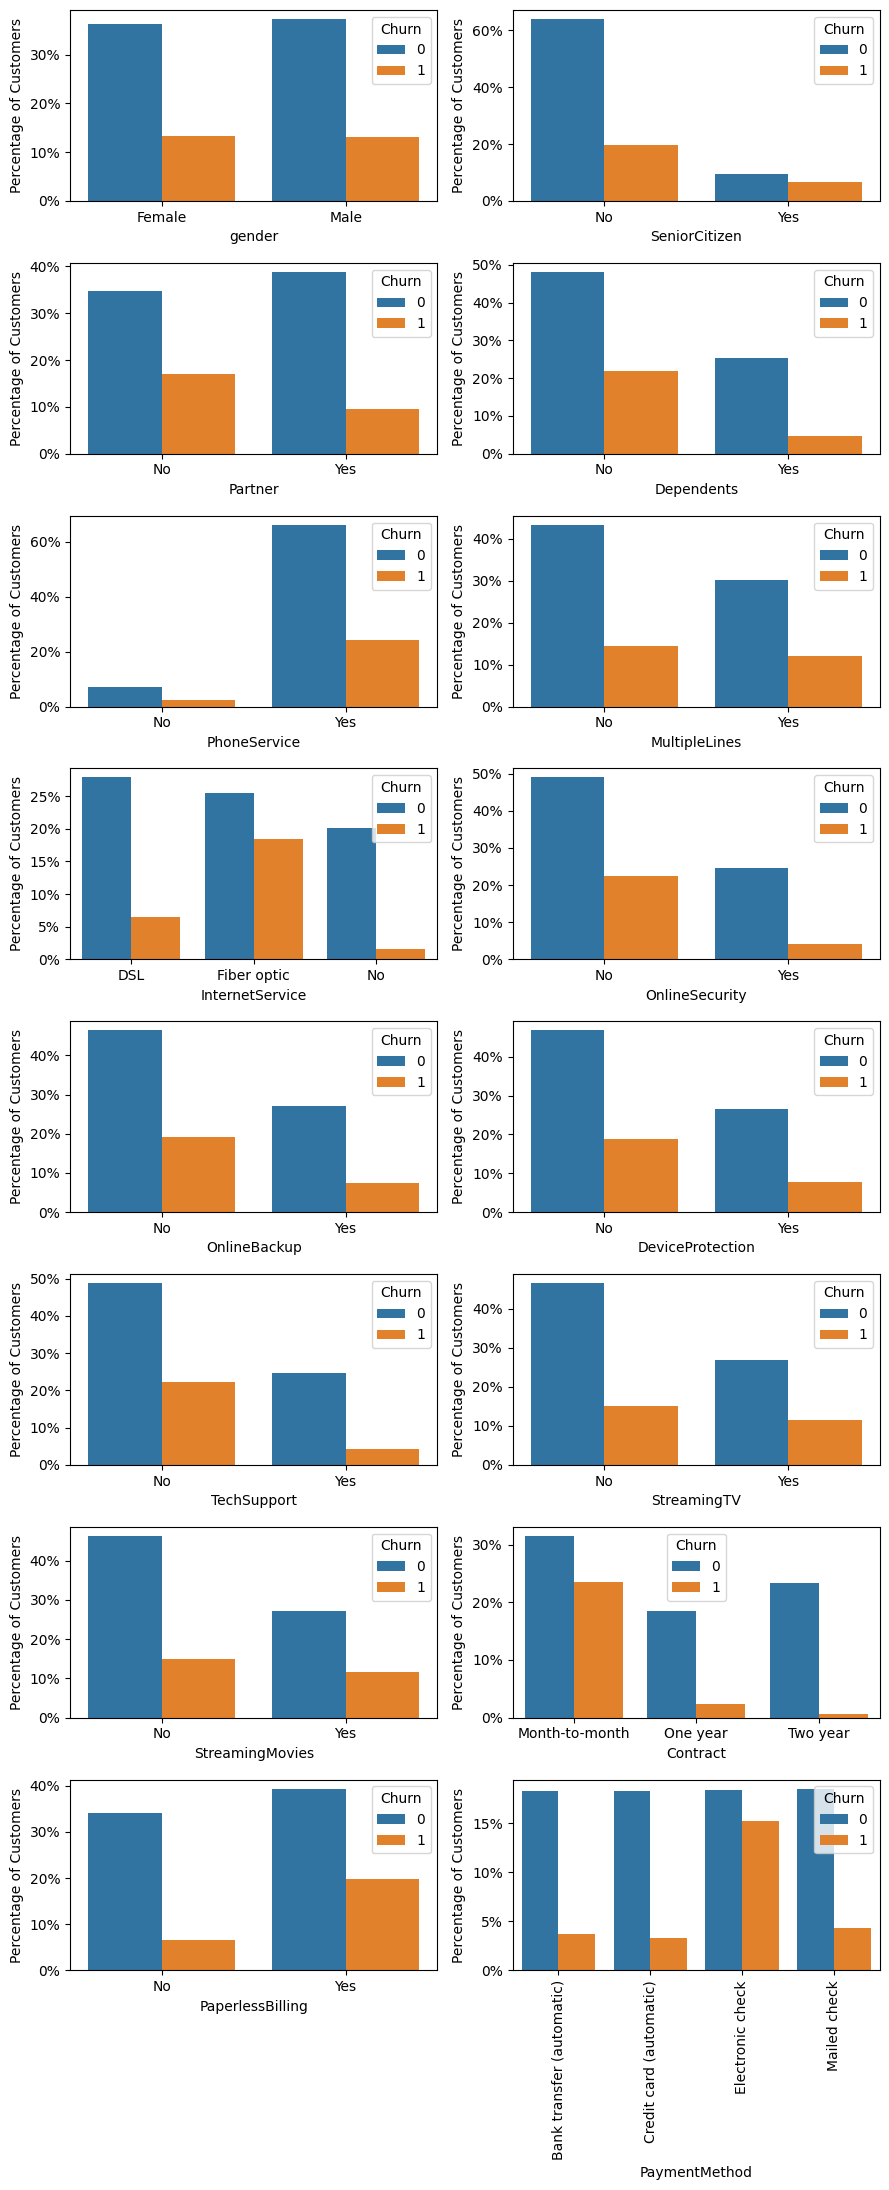

In [35]:
feat_cat_no_churn = [feat for feat in feat_cat if feat != "Churn"]

fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(9, 22))
ax = ax.flatten()

for idx, col in enumerate(feat_cat_no_churn):
    sns.countplot(data=df_cats, x=col, hue="Churn", ax=ax[idx], stat="percent")
    
    ax[idx].yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax[idx].set_ylabel("Percentage of Customers")
    
    if col == "PaymentMethod":
        ax[idx].set_xticklabels(ax[idx].get_xticklabels(), rotation=90)
    
    #if idx == 17:
    #    fig.delaxes(ax[idx])

plt.tight_layout()
plt.show()

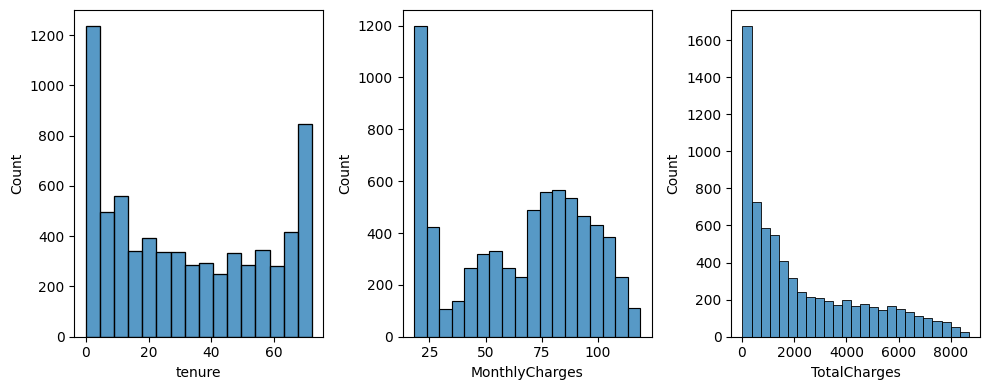

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
ax = ax.flatten()

for idx, col in enumerate(feat_num):
    sns.histplot(data=df_cats, x=col, ax=ax[idx])

plt.tight_layout()
plt.show()

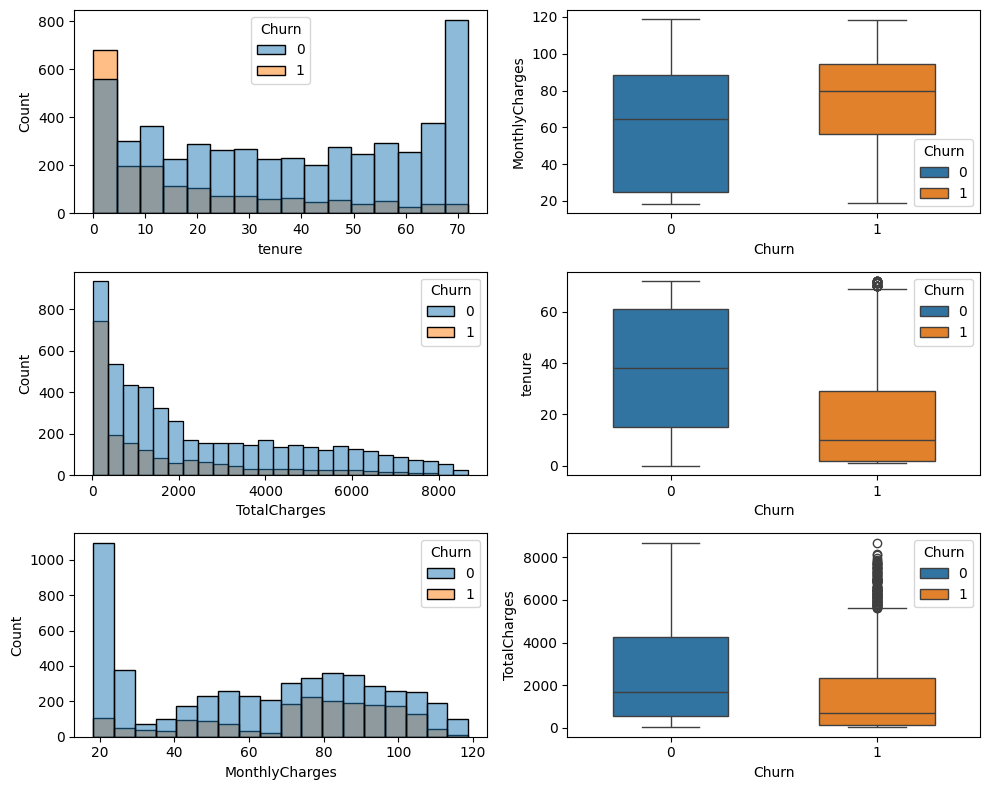

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
ax = ax.flatten()

for idx, col in enumerate(feat_num*2):
    if idx % 2 == 0:
        sns.histplot(data=df_cats, x=col, hue="Churn", ax=ax[idx])
    else:
        sns.boxplot(data=df_cats, y=col, x="Churn", hue="Churn", gap=0.3, ax=ax[idx])

plt.tight_layout()
plt.show()

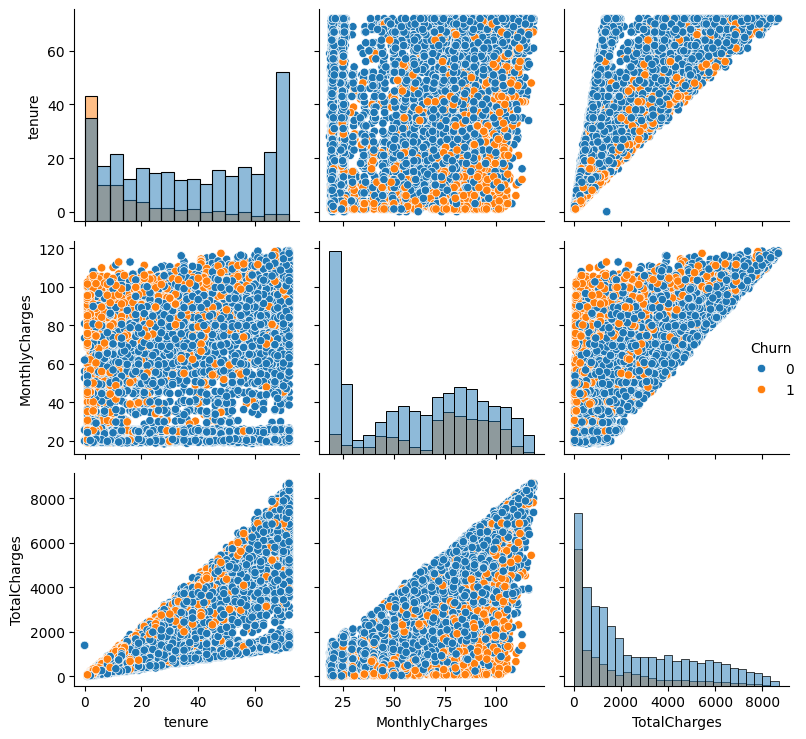

In [19]:
sns.pairplot(
    data=df_cats,
    x_vars=feat_num.append("Churn"),
    y_vars=feat_num.append("Churn"),
    hue="Churn",
    diag_kind="hist"
)

plt.tight_layout()
plt.show()

<Axes: >

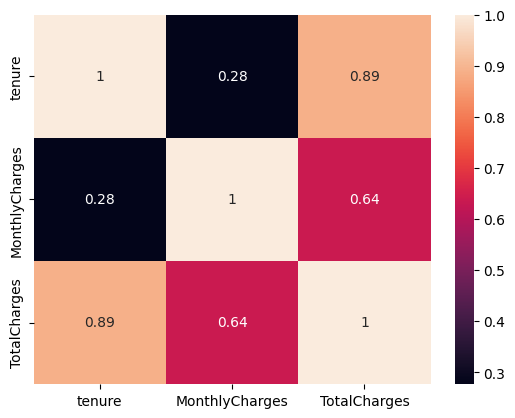

In [27]:
sns.heatmap(df_cats[feat_num].corr(method="spearman"), annot=True)

In [20]:
df_lgbm = df_filled.copy()

df_lgbm.to_csv("../data/processed/df_lgbm.csv")